# Installation

In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /private/var/folders/74/dvlrgbz96cz_9yb59920m5hc0000gn/T/pip-req-build-h9spbx30
  Running command git clone -q https://github.com/tensorflow/examples.git /private/var/folders/74/dvlrgbz96cz_9yb59920m5hc0000gn/T/pip-req-build-h9spbx30
  Resolved https://github.com/tensorflow/examples.git to commit 56524742e739278cc52e2fcfc978e81d64cfcbd3


In [2]:
import os
import time

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [43]:
# Prompts the TensorFlow runtime to tune the number of elements to prefetch dynamically at runtime.
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Enable eager execution for variable declarations.
tf.config.experimental_run_functions_eagerly(True)

# Input Pipeline

In [9]:
dataset, metadata = tfds.load("cycle_gan/horse2zebra", with_info=True, as_supervised=True)
train_horses, train_zebras = dataset["trainA"], dataset["trainB"]
test_horses, test_zebras = dataset["testA"], dataset["testB"]

In [45]:
train_horses

<BatchDataset shapes: (None, 256, 256, 3), types: tf.float32>

# Constants

In [10]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [11]:
def random_crop(image):
    cropped = tf.image.random_crop(image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped

In [12]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [14]:
def jitter(image):
    image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    image = tf.image.random_flip_left_right(image)
    return image

In [15]:
def preprocess_image_train(image, label):
    image = jitter(image)
    image = normalize(image)
    return image

In [16]:
def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [19]:
train_horses = train_horses.cache().map(preprocess_image_train,
                                        num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(preprocess_image_train,
                                        num_parallel_calls=AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(preprocess_image_test,
                              num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(preprocess_image_test,
                              num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [20]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

2022-02-22 21:44:59.525691: W tensorflow/core/kernels/data/cache_dataset_ops.cc:820] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-02-22 21:45:01.226273: W tensorflow/core/kernels/data/cache_dataset_ops.cc:820] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


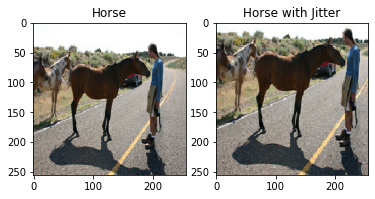

In [21]:
plt.subplot(121)
plt.title("Horse")
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Horse with Jitter")
plt.imshow(jitter(sample_horse[0]) * 0.5 + 0.5)

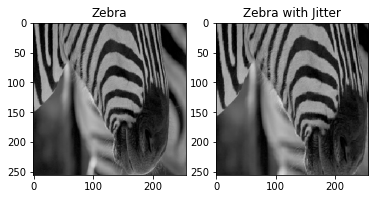

In [22]:
plt.subplot(121)
plt.title("Zebra")
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title("Zebra with Jitter")
plt.imshow(jitter(sample_zebra[0]) * 0.5 + 0.5)

# Pix2Pix Setup

In [24]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")

discriminator_x = pix2pix.discriminator(norm_type="instancenorm", target=False)
discriminator_y = pix2pix.discriminator(norm_type="instancenorm", target=False)

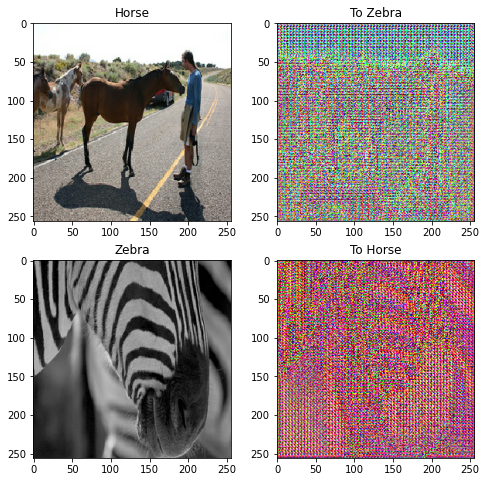

In [25]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ["Horse", "To Zebra", "Zebra", "To Horse"]

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)

plt.show()

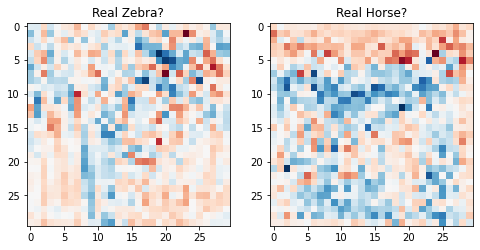

In [26]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title("Real Zebra?")
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title("Real Horse?")
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Loss Function

In [27]:
LAMBDA = 10

In [28]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [29]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [30]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [31]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [40]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [32]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [33]:
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoint Setup

In [34]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!")

# Training

In [35]:
EPOCHS = 40

In [37]:
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ["Input Image", "Predicted Image"]
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # Get the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [38]:
@tf.function
def train_step(real_x, real_y):
    # Persistent is set to True because the tape is used more than once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Calculate the loss.
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator.
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer.
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [44]:
for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        train_step(image_x, image_y)
        if n % 10 == 0:
            print(".", end="")
        n += 1
    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model is clearly visible.
    generate_images(generator_g, sample_horse)
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print("Saving checkpoint for epoch {} at {}".format(epoch+1,ckpt_save_path))
    print("Time taken for epoch {} is {} sec\n".format(epoch + 1, time.time()-start))

.

2022-02-22 22:05:17.812174: W tensorflow/core/kernels/data/cache_dataset_ops.cc:820] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-02-22 22:05:17.840118: W tensorflow/core/kernels/data/cache_dataset_ops.cc:820] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


KeyboardInterrupt: 

# Test

In [ ]:
for image in test_horses.take(5):
    generate_images(generator_g, image)